# Task 1

Imports necessary libraries for creating a dataset to load the provided files.

In [1]:
from torch.utils.data import Dataset
import numpy as np

Implements `LetterDataSet` class by implementing `__init__`, `__getitem__` and `__len__` from parent `Dataset` class

Constructor
* Reads size of data from input file location
* Reads size of image from input file location
* Uses data and image sizes to load images and their corresponding labels from the images and labels files
* Stores transform parameters

Accessor
* Transforms images and labels accorsing to transform parameters from object
* Return dictionary of image and corresponding label

Len
* Returns number of data points (images and their labels)

In [2]:
class LettersDataSet(Dataset):
  """LettersDataSet class."""
  def __init__(self, labels_file: str, images_file: str, transform=None, target_transform=None):
    # data loading
    with open(images_file, 'rb') as f:
      self.num = int.from_bytes(f.read(4), 'big')
      rows = int.from_bytes(f.read(4), 'big')
      cols = int.from_bytes(f.read(4), 'big')
    self.images = np.fromfile(images_file, dtype=np.dtype((np.uint8, (rows,cols))), offset=12)
    self.labels = np.fromfile(labels_file, dtype='B', offset=4)
    self.transform = transform
    self.target_transform = target_transform

  def __getitem__(self, index):
    # dataset[0]
    image = self.transform(self.images[index]) if self.transform else self.images[index]
    label = self.target_transform(self.labels[index]) if self.target_transform else self.labels[index]
    return {'image': image, 'label': label}

  def __len__(self):
    # len(dataset)
    return self.num

Initializes dataset from files provided on mounted drive

In [3]:
dataset = LettersDataSet('/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-labels-idx1-ubyte',
                         '/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-images-idx3-ubyte')

# Task 2

Imports matplotlib to plot the images.

In [4]:
import matplotlib.pyplot as plt

Creates a figure and plots the images #1 - #20. Transposing the images was necessary to get them upright.

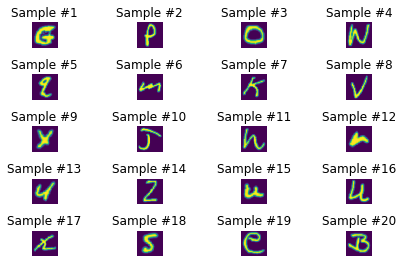

In [5]:
fig = plt.figure()

for i in range(1, 21):
  sample = dataset[i]
  ax = plt.subplot(5, 4, i)
  plt.tight_layout()
  ax.set_title(f"Sample #{i}")
  ax.axis('off')
  plt.imshow(np.transpose(sample['image']))

plt.show()

# Task 3

Follows the exmaple provided closely. (https://github.com/erykml/medium_articles/blob/master/Computer%20Vision/lenet5_pytorch.ipynb)

Imports pytorch essential libraries to implement nueral network.

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
import torchvision
import torch.nn.functional as F
from datetime import datetime 

Parameters changed from example:
* `IMG_SIZE`: 28, since images are 28x28
* `N_CLASSES`: 26, since model is recognizing letters of the alphabet.

The other parameters are training parameters that may affect accuracy of model. I left most the same as in exmaple since results were sufficient.

In [7]:
# parameters
RANDOM_SEED = 42
LEARNING_RATE = 0.001
BATCH_SIZE = 26
N_EPOCHS = 15

IMG_SIZE = 28
N_CLASSES = 26

## Helper functions

These helper functions were taken from the example with small modification to how the data was accessed in the loader loops since the accessor method for this dataset is different than builtin MNIST dataset used in example.

In [8]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''
    
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        model.eval()
        for loader in data_loader:
          X = loader['image']
          y_true = loader['label']
          X = X.to(device)
          y_true = y_true.to(device)

          _, y_prob = model(X)
          _, predicted_labels = torch.max(y_prob, 1)

          n += y_true.size(0)
          correct_pred += (predicted_labels == y_true).sum()

    return correct_pred.float() / n

def plot_losses(train_losses, valid_losses):
    '''
    Function for plotting training and validation losses
    '''
    
    # temporarily change the style of the plots to seaborn 
    plt.style.use('seaborn')

    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)

    fig, ax = plt.subplots(figsize = (8, 4.5))

    ax.plot(train_losses, color='blue', label='Training loss') 
    ax.plot(valid_losses, color='red', label='Validation loss')
    ax.set(title="Loss over epochs", 
            xlabel='Epoch',
            ylabel='Loss') 
    ax.legend()
    fig.show()
    
    # change the plot style to default
    plt.style.use('default')
    
def train(train_loader, model, criterion, optimizer, device):
    '''
    Function for the training step of the training loop
    '''

    model.train()
    running_loss = 0
    
    for loader in train_loader:
      X = loader['image']
      y_true = loader['label']

      optimizer.zero_grad()
      
      X = X.to(device)
      y_true = y_true.to(device)
  
      # Forward pass
      y_hat, _ = model(X) 
      loss = criterion(y_hat, y_true) 
      running_loss += loss.item() * X.size(0)

      # Backward pass
      loss.backward()
      optimizer.step()
      
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
   
    model.eval()
    running_loss = 0
    
    for loader in valid_loader:
      X = loader['image']
      y_true = loader['label']
      X = X.to(device)
      y_true = y_true.to(device)

      # Forward pass and record loss
      y_hat, _ = model(X) 
      loss = criterion(y_hat, y_true) 
      running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
        
    return model, epoch_loss

def training_loop(model, criterion, optimizer, train_loader, valid_loader, epochs, device, print_every=1):
    '''
    Function defining the entire training loop
    '''
    
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
 
    # Train model
    for epoch in range(0, epochs):

      # training
      model, optimizer, train_loss = train(train_loader, model, criterion, optimizer, device)
      train_losses.append(train_loss)

      # validation
      with torch.no_grad():
        model, valid_loss = validate(valid_loader, model, criterion, device)
        valid_losses.append(valid_loss)

      if epoch % print_every == (print_every - 1):
          
        train_acc = get_accuracy(model, train_loader, device=device)
        valid_acc = get_accuracy(model, valid_loader, device=device)
            
        print(f'{datetime.now().time().replace(microsecond=0)} --- '
              f'Epoch: {epoch}\t'
              f'Train loss: {train_loss:.4f}\t'
              f'Valid loss: {valid_loss:.4f}\t'
              f'Train accuracy: {100 * train_acc:.2f}\t'
              f'Valid accuracy: {100 * valid_acc:.2f}')

    plot_losses(train_losses, valid_losses)
    
    return model, optimizer, (train_losses, valid_losses)

Sets up training and testing datasets. Certain tranformations of the dataset are necessary before they can be used in the model
* `ToPILImage`: certain function only work with PIL images while data is currently stores in numpy array.
* `Resize`: Ensures image is in 28x28 format
* `ToTensor`: Scales image to [0,1] range and converts to Tensor for the model
*`Lamda`: Subtracts 1 from all of the labels since they range from [1,26] instead of [0,25]

In [9]:
trfms = torchvision.transforms.Compose([torchvision.transforms.ToPILImage(), torchvision.transforms.Resize((28, 28)), torchvision.transforms.ToTensor()])
target_trfms = torchvision.transforms.Lambda(lambda x: x-1)
train_dataset = LettersDataSet('/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-labels-idx1-ubyte',
                         '/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-train-images-idx3-ubyte', transform=trfms, target_transform=target_trfms)
test_dataset = LettersDataSet('/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-test-labels-idx1-ubyte',
                         '/content/drive/MyDrive/CSCE_489/hw3/hw3-letters-test-images-idx3-ubyte', transform=trfms, target_transform=target_trfms)

Creates loaders for the datasets.

In [10]:
train_loader = DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False)

Implements the Convolutional Neural Network. The kernel size was reduced to a 3x3 since our images are smaller than used in the example. The classifier needed to be updated to reflect the change in kernel size since there ae more features than in example.

In [11]:
class LeNet5(nn.Module):

    def __init__(self, n_classes):
        super(LeNet5, self).__init__()
        
        self.feature_extractor = nn.Sequential(            
            nn.Conv2d(in_channels=1, out_channels=6, kernel_size=3, stride=1), # 6x26x26 (4056)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # 6x13x13 (1014)
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride=1), # 16x10x10 (1600)
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2), # 16x5x5 (400)
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=3, stride=1), # 120x3x3 (1080)
            nn.Tanh()
        )

        self.classifier = nn.Sequential(
            nn.Linear(in_features=1080, out_features=100),
            nn.Tanh(),
            nn.Linear(in_features=100, out_features=n_classes),
        )


    def forward(self, x):
        x = self.feature_extractor(x)
        x = torch.flatten(x, 1)
        logits = self.classifier(x)
        probs = F.softmax(logits, dim=1)
        return logits, probs

Sets device first to CPU for time comparison with GPU.

In [12]:
DEVICE = 'cpu'

Initializes the model.

In [13]:
torch.manual_seed(RANDOM_SEED)

model = LeNet5(N_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

Trains the model and evaluates its accuracy over time. We can see that as the epochs grow the loss is reduced meaning the model is getting more accurate. In the final epoch the validation accurary was > 90% (91.84%).

22:42:33 --- Epoch: 0	Train loss: 0.6709	Valid loss: 0.4209	Train accuracy: 87.45	Valid accuracy: 86.95
22:44:20 --- Epoch: 1	Train loss: 0.3661	Valid loss: 0.3598	Train accuracy: 89.14	Valid accuracy: 88.61
22:46:07 --- Epoch: 2	Train loss: 0.3155	Valid loss: 0.3286	Train accuracy: 90.48	Valid accuracy: 89.77
22:47:53 --- Epoch: 3	Train loss: 0.2892	Valid loss: 0.3189	Train accuracy: 91.15	Valid accuracy: 90.24
22:49:38 --- Epoch: 4	Train loss: 0.2709	Valid loss: 0.3042	Train accuracy: 91.38	Valid accuracy: 90.36
22:51:25 --- Epoch: 5	Train loss: 0.2615	Valid loss: 0.2868	Train accuracy: 92.12	Valid accuracy: 90.88
22:53:12 --- Epoch: 6	Train loss: 0.2515	Valid loss: 0.2927	Train accuracy: 92.12	Valid accuracy: 90.87
22:54:57 --- Epoch: 7	Train loss: 0.2411	Valid loss: 0.2854	Train accuracy: 92.26	Valid accuracy: 91.06
22:56:43 --- Epoch: 8	Train loss: 0.2335	Valid loss: 0.2729	Train accuracy: 92.93	Valid accuracy: 91.50
22:58:28 --- Epoch: 9	Train loss: 0.2250	Valid loss: 0.2809	Trai

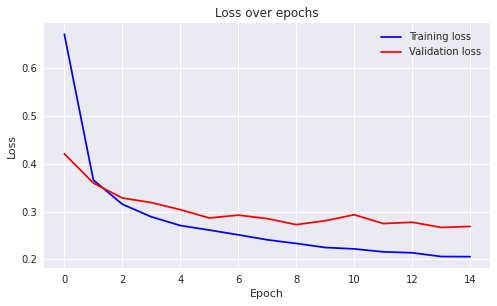

In [90]:
model, optimizer, _ = training_loop(model, criterion, optimizer, train_loader, test_loader, N_EPOCHS, DEVICE)

Using CPU training took 1690.784s (~28 min)

# Task 4

Perfroms Task 3 with a harware accelerator (GPU) instead to compare training time.

In [111]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
model_gpu = LeNet5(N_CLASSES).to(DEVICE)
optimizer_gpu = torch.optim.Adam(model_gpu.parameters(), lr=LEARNING_RATE)
criterion_gpu = nn.CrossEntropyLoss()

18:26:23 --- Epoch: 0	Train loss: 0.6607	Valid loss: 0.4122	Train accuracy: 87.87	Valid accuracy: 87.42
18:27:22 --- Epoch: 1	Train loss: 0.3596	Valid loss: 0.3493	Train accuracy: 89.57	Valid accuracy: 88.62
18:28:22 --- Epoch: 2	Train loss: 0.3132	Valid loss: 0.3235	Train accuracy: 90.99	Valid accuracy: 89.94
18:29:22 --- Epoch: 3	Train loss: 0.2860	Valid loss: 0.3095	Train accuracy: 91.05	Valid accuracy: 90.11
18:30:21 --- Epoch: 4	Train loss: 0.2692	Valid loss: 0.2958	Train accuracy: 91.65	Valid accuracy: 90.62
18:31:21 --- Epoch: 5	Train loss: 0.2562	Valid loss: 0.2916	Train accuracy: 92.04	Valid accuracy: 90.80
18:32:19 --- Epoch: 6	Train loss: 0.2440	Valid loss: 0.2797	Train accuracy: 92.28	Valid accuracy: 91.20
18:33:18 --- Epoch: 7	Train loss: 0.2349	Valid loss: 0.2838	Train accuracy: 92.60	Valid accuracy: 91.22
18:34:17 --- Epoch: 8	Train loss: 0.2313	Valid loss: 0.2733	Train accuracy: 92.76	Valid accuracy: 91.57
18:35:15 --- Epoch: 9	Train loss: 0.2253	Valid loss: 0.2710	Trai

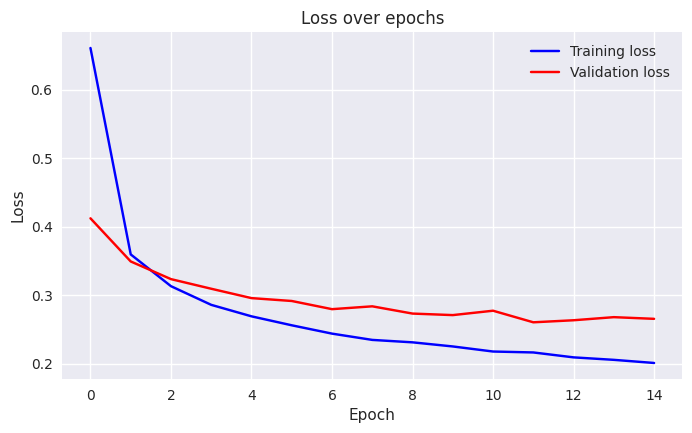

In [17]:
model_gpu, optimizer_gpu, _ = training_loop(model_gpu, criterion_gpu, optimizer_gpu, train_loader, test_loader, N_EPOCHS, DEVICE)

Using GPU training took 901.647s (~15 min), a 53.33% speedup.

# Task 5

Imports necessary libraries for creating and plotting the confusion matrix.

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd

Evaluates the model based on the test dataset.

In [108]:
y_pred = []
y_test = []
for loader in test_loader:
    X = loader['image']
    labels = loader['label']
    output = model(X)
    output = (torch.max(torch.exp(output[0]), 1)[1]).data.cpu().numpy()
    y_pred.extend(output)
    labels = labels.data.cpu().numpy()
    y_test.extend(labels)

Builds confusion matrix

In [109]:
cf_matrix = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cf_matrix, index = [i for i in range(1, 27)],
                     columns = [i for i in range(1, 27)])

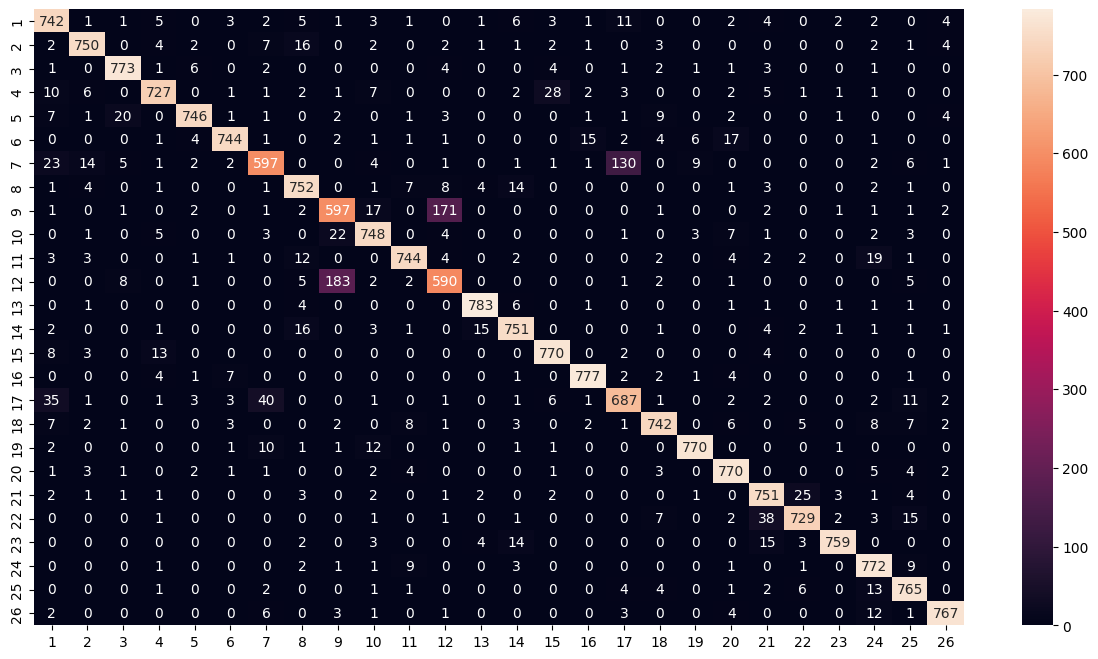

In [110]:
plt.figure(figsize = (15,8))
sn.heatmap(df_cm, annot=True, fmt='g')
plt.show()

The results seen in the confusion matrix match the accuracy observed above.